In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Problem 1(b)

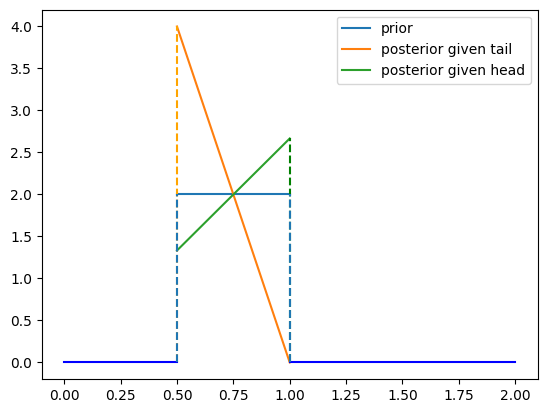

In [21]:
x_axis = np.linspace(1/2,1,100)
x_axis_0 = np.linspace(0, 1/2)
x_axis_1 = np.linspace(1, 2)
prior = lambda x: 2 if 1 / 2 <= x <= 1 else 0
posterior_0 = lambda x: 8 * (1 - x) if 1 / 2 <= x <= 1 else 0
posterior_1 = lambda x: 8 / 3 * x if 1 / 2 <= x <= 1 else 0
plt.plot(x_axis, [prior(x) for x in x_axis], label="prior")
plt.plot(x_axis, [posterior_0(x) for x in x_axis], label="posterior given tail")
plt.plot(x_axis, [posterior_1(x) for x in x_axis], label="posterior given head")
plt.plot(x_axis_0, [0 for i in range(len(x_axis_0))], color = "b")
plt.plot(x_axis_1, [0 for i in range(len(x_axis_1))], color = "b")

plt.vlines(0.5, ymin=0, ymax=4, linestyle="--", color="orange")
plt.vlines(1, ymin=0, ymax=posterior_1(1), linestyle="--", color="green")
plt.vlines([0.5,1], ymin=0, ymax=2, linestyle="--")
plt.legend()
plt.show()

# Problem 3

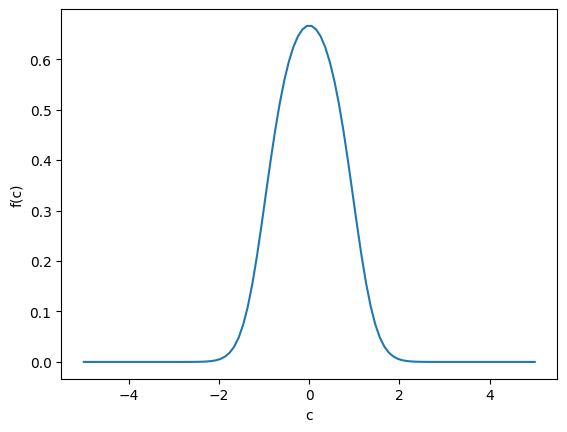

In [28]:
func_ = lambda x: 1 / (1 + 1 / 2 * np.exp(3 / 2 * x ** 2))
x_axis = np.linspace(-5,5, 100)
plt.plot(x_axis, [func_(x) for x in x_axis])
plt.xlabel("c")
plt.ylabel("f(c)")
plt.show()

# Problem 4

## Load Data

In [45]:
def ind_x_eq_val(x, val):
    return np.where(x==val)[0]

def count_x_eq_val(x, val):
    return len(ind_x_eq_val(x, val))/float(len(x))

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) / sig / np.sqrt(2 * np.pi)



data, target = load_breast_cancer(return_X_y=True, as_frame=True)
train_X, test_X, train_y, test_y = train_test_split(data, target, test_size=0.3, random_state=2022)
print(train_X.shape, test_X.shape)
train_X.columns

(398, 30) (171, 30)


Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

## Gaussian Mixture Model
### Estimate $p_{\tilde{c}}(c)$

In [37]:
# Estimate the pmf of C
n = len(data)
P_C0 = np.sum(train_y == 0) / n # TODO
P_C1 = np.sum(train_y == 1) / n# TODO
P_C0, P_C1

(0.2530755711775044, 0.44639718804920914)

### Estimate $f_{\tilde{r}|\tilde{c}} (r|c)$ and $f_{\tilde{t}|\tilde{c}} (t|c)$ with MLE

In [46]:
# Gaussian Model Assumption
## Estimate conditional pdf of R given C
mean_R_C = np.zeros(2)
std_R_C = np.zeros(2)
mean_R_C[0]= np.mean(train_X.loc[(train_y == 0).index, "mean radius"])
std_R_C[0] = np.std(train_X.loc[(train_y == 0).index, "mean radius"])


mean_R_C[1]= np.mean(train_X.loc[(train_y == 1).index, "mean radius"])
std_R_C[1] = np.std(train_X.loc[(train_y == 1).index, "mean radius"])


## Estimate conditional pdf of T given C
mean_T_C = np.zeros(2)
std_T_C = np.zeros(2)
mean_T_C[0]= np.mean(train_X.loc[(train_y == 0).index, "mean texture"] )
std_T_C[0] = np.std(train_X.loc[(train_y == 0).index, "mean texture"])
mean_T_C[1]= np.mean(train_X.loc[(train_y == 1).index, "mean texture"] )
std_T_C[1] = np.std(train_X.loc[(train_y == 1).index, "mean texture"])

### Plot the pdf and normalized histogram of $\tilde{r}|\tilde{c}$ and $\tilde{t}|\tilde{c}$

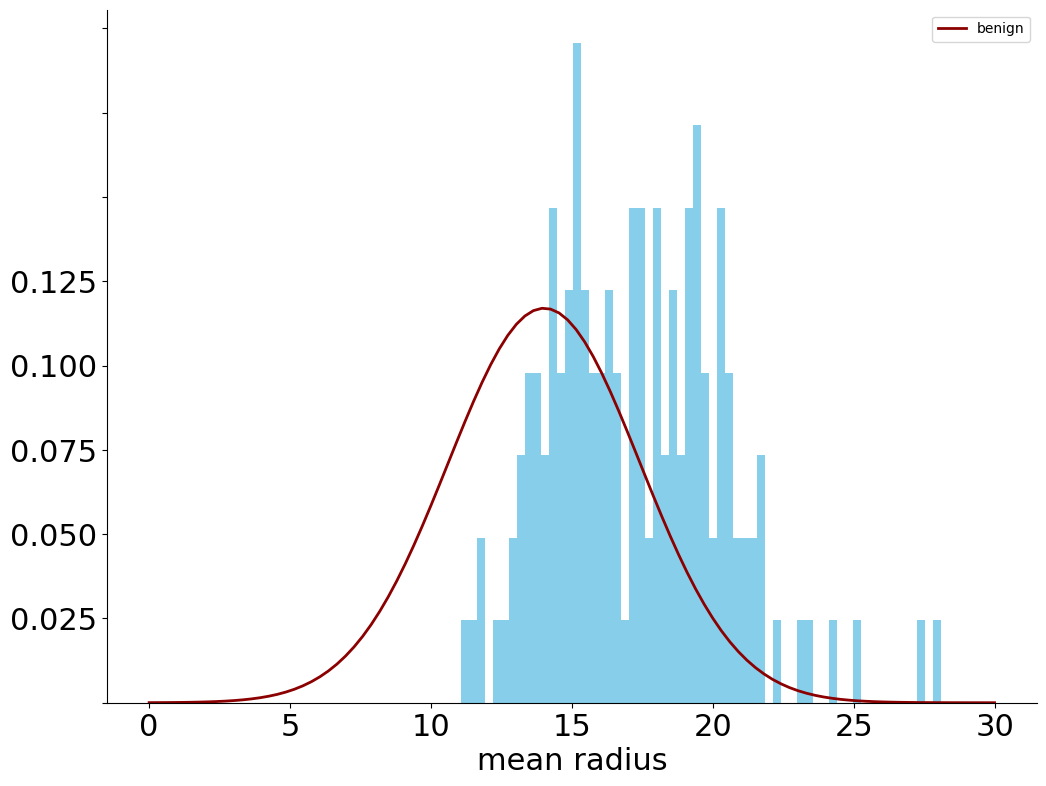

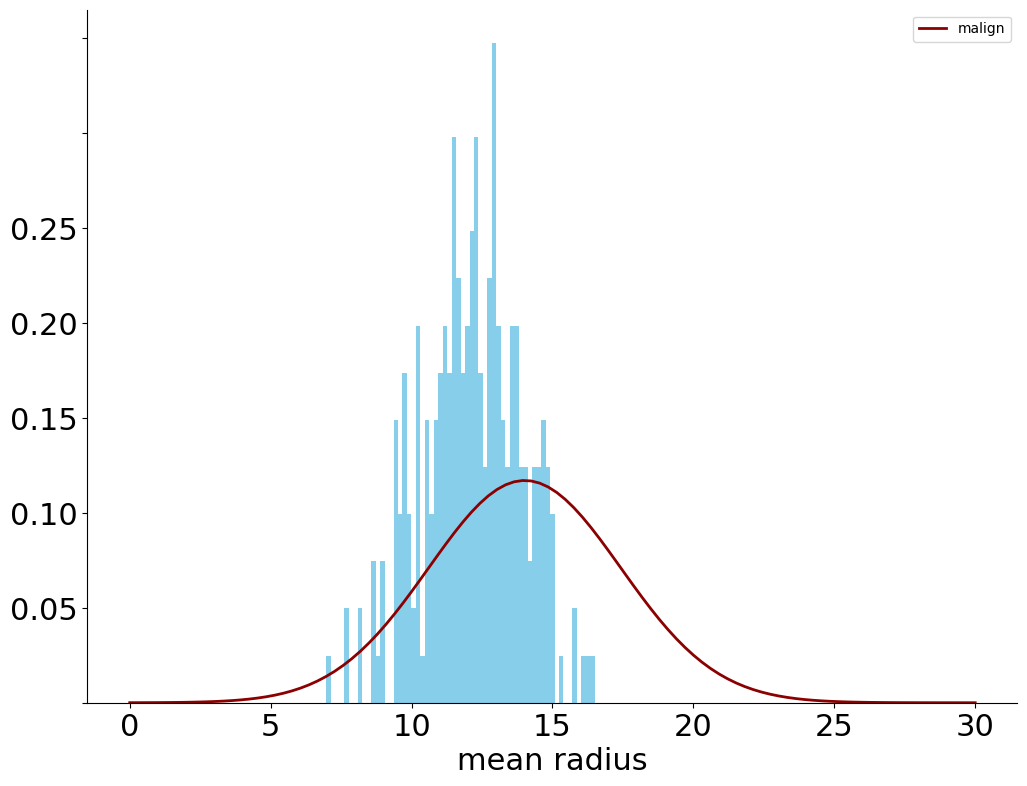

In [52]:
n_plot = 100
for i in range(2):
    plt.figure(figsize=(12, 9))  
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 
    yticks = ax.yaxis.get_major_ticks()
    yticks[0].label1.set_visible(False) 
    plt.xticks(fontsize=22) 
    plt.yticks(fontsize=22) 
    plt.xlabel("mean radius", fontsize=22)  
    plt.hist(train_X["mean radius"].iloc[ind_x_eq_val(train_y, i)],
             60,density=True, stacked=True,edgecolor = "none", color="skyblue")
    plt.plot(np.linspace(0, 30, n_plot),gaussian(np.linspace(0, 30, n_plot), 
                     mean_R_C[i], std_R_C[i]), color="darkred", lw=2, label=f"{'benign' if i == 0 else 'malign'}")
    plt.legend()
    plt.savefig("plot_{}.pdf".format(i), bbox_inches='tight')

### **MAP decision** compute posterior $p_{\tilde{c} \mid \tilde{t},\tilde{r}}$ and derive MAP for each test sample. What's the error rate?

In [108]:
def compute_MAP_Estimate(test_X):
    radius = test_X["mean radius"]
    texture = test_X["mean texture"]
    arg_0 = gaussian(radius, mean_R_C[0], std_R_C[0]) * gaussian(radius, mean_T_C[0], std_T_C[0]) * P_C0
    arg_1 = gaussian(radius, mean_R_C[1], std_R_C[1]) * gaussian(radius, mean_T_C[1], std_T_C[1]) * P_C1
    return (arg_0 < arg_1).astype(int)

MAP_estimate_R_T = compute_MAP_Estimate(test_X) 
error_rate_R_T = np.sum(np.abs(MAP_estimate_R_T - test_y)) / len(test_y)
print("Probability of error using radius and texture " + str(error_rate_R_T))

Probability of error using radius and texture 0.39766081871345027


In [107]:
# Training_gauss
# kde function at an arbitrary data point 
def train_mle(data_points):
    """
    Return the pdf trained from the data points and bandwidth pre-specified 
    """
    mu_hat = np.mean(data_points)
    sigma_hat = np.sqrt(np.mean((data_points - np.mean(data_points))**2))
    
    def trained_mle(t):
        return gaussian(t, mu_hat, sigma_hat)
    
    return trained_mle

def estimate_conditional_pdf_mle():
    ## Estimate conditional pdf of R given C
    P_R_C0 = trained_mle(train_X.loc[(train_y == 0).index, "mean radius"]) 
    P_R_C1 = trained_mle(train_X.loc[(train_y == 1).index, "mean radius"])


    ## Estimate conditional pdf of T given C
    P_T_C0 = train_kde(train_X.loc[(train_y == 0).index, "mean texture"]) 
    P_T_C1 = train_kde(train_X.loc[(train_y == 1).index, "mean texture"]) 
    
    return P_R_C0, P_R_C1, P_T_C0, P_T_C1

## Kernel Density Estimation (With Gaussian Kernel)
### Training

In [105]:
bandwidth = 1.0


# kde function at an arbitrary data point
def gaussian_kernel(t, center, bandwidth):
    return 1 / (bandwidth * np.sqrt(2 * np.pi)) * np.exp(- 0.5 * ((t - center)/ bandwidth) ** 2);


# Compute kde for a single value
def kde_gauss(t, data_points, bandwidth):
    return (1 / len(data_points)) * sum([gaussian_kernel(t, data, bandwidth) for data in data_points]);
    
    
def train_kde(data_points, bandwidth, model_type):
    """
    Return the pdf trained from the data points and bandwidth pre-specified 
    """
    def trained_kde(t):
        return model_type(t, data_points, bandwidth)
    
    return trained_kde

def estimate_conditional_pdf(training_model_type,bandwidth):
    ## Estimate conditional pdf of R given C
    P_R_C0 = train_kde(train_X.loc[(train_y == 0).index, "mean radius"], bandwidth, training_model_type) 
    P_R_C1 = train_kde(train_X.loc[(train_y == 1).index, "mean radius"], bandwidth, training_model_type)


    ## Estimate conditional pdf of T given C
    P_T_C0 = train_kde(train_X.loc[(train_y == 0).index, "mean texture"], bandwidth, training_model_type) 
    P_T_C1 = train_kde(train_X.loc[(train_y == 1).index, "mean texture"], bandwidth, training_model_type) 
    
    return P_R_C0, P_R_C1, P_T_C0, P_T_C1
P_R_C0, P_R_C1, P_T_C0, P_T_C1 = estimate_conditional_pdf(kde_gauss, bandwidth)

### Testing

In [97]:
def compute_MAP_Estimate_KDE(test_X, P_R_C0, P_R_C1, P_T_C0, P_T_C1):
    radius = test_X["mean radius"]
    texture = test_X["mean texture"]
    n = len(radius)
    arg_0 = np.array([P_R_C0(radius[i]) * P_T_C0(texture[i]) * P_C0 for i in radius.index])
    arg_1 = np.array([P_R_C1(texture[i]) * P_T_C1(texture[i]) * P_C1 for i in radius.index])
    
    return (arg_0 < arg_1).astype(int)


MAP_estimate_R_T = compute_MAP_Estimate_KDE(test_X,P_R_C0, P_R_C1, P_T_C0, P_T_C1)
error_rate_R_T = np.sum(np.abs(MAP_estimate_R_T - test_y)) / len(test_y)
print("Probability of error using radius and texture " + str(error_rate_R_T))

Probability of error using radius and texture 0.5614035087719298


### Grid Search on different bandwidth

Probability of error using radius and texture 0.49122807017543857
Probability of error using radius and texture 0.4853801169590643
Probability of error using radius and texture 0.5789473684210527
Probability of error using radius and texture 0.5263157894736842
Probability of error using radius and texture 0.42105263157894735
Probability of error using radius and texture 0.39766081871345027
Probability of error using radius and texture 0.39766081871345027
Probability of error using radius and texture 0.39766081871345027


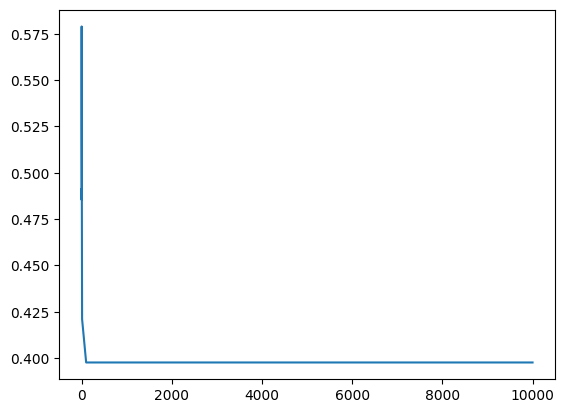

In [101]:
model_mapping = {"gauss": kde_gauss, "flat": kde_rect}

def main(model_type):
    bandwidths = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    error_rates = []
    for bandwidth in bandwidths:
        P_R_C0, P_R_C1, P_T_C0, P_T_C1 = estimate_conditional_pdf(model_mapping[model_type], bandwidth)
        MAP_estimate_R_T = compute_MAP_Estimate_KDE(test_X,P_R_C0, P_R_C1, P_T_C0, P_T_C1)
        error_rate_R_T = np.sum(np.abs(MAP_estimate_R_T - test_y)) / len(test_y)
        error_rates.append(error_rate_R_T)
        print("Probability of error using radius and texture " + str(error_rate_R_T))
    
    
    plt.plot(bandwidths, error_rates)

main("gauss")

## Kernel Density Estimation (With Rectangular Kernel, for Copmarison)
### Training

In [95]:
bandwidth = 1.0

# kde function at an arbitrary data point
def rectangular_kernel(t, center, bandwidth):
    return 1 / bandwidth if center - bandwidth / 2 <= t <= center + bandwidth / 2 else 0


# Compute kde for a single value
def kde_rect(t, data_points, bandwidth):
    return (1 / len(data_points)) * sum([rectangular_kernel(t, data, bandwidth) for data in data_points]);


P_R_C0, P_R_C1, P_T_C0, P_T_C1 = estimate_conditional_pdf(kde_rect, bandwidth)

### Testing

In [96]:
MAP_estimate_R_T = compute_MAP_Estimate_KDE(test_X,P_R_C0, P_R_C1, P_T_C0, P_T_C1)
error_rate_R_T = np.sum(np.abs(MAP_estimate_R_T - test_y)) / len(test_y)
print("Probability of error using radius and texture " + str(error_rate_R_T))

Probability of error using radius and texture 0.5614035087719298


### Grid Search on different bandwidth

Probability of error using radius and texture 0.5847953216374269
Probability of error using radius and texture 0.5847953216374269
Probability of error using radius and texture 0.5380116959064327
Probability of error using radius and texture 0.5614035087719298
Probability of error using radius and texture 0.3742690058479532
Probability of error using radius and texture 0.39766081871345027
Probability of error using radius and texture 0.39766081871345027
Probability of error using radius and texture 0.39766081871345027


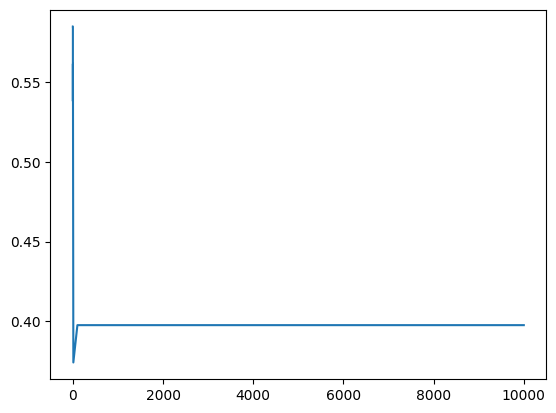

In [102]:
main("flat")